In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [2]:
input_fn = './propagation_inputs.csv'

model = 'gpt2'
scores_fn = f'./70M/scores:{model}.csv'

In [3]:
input_df = pd.read_csv(input_fn, header=[0])

In [4]:
score_df = pd.read_csv(scores_fn, header=None)
score_df.columns = ['example_idx', 'w1_prob', 'w2_prob', 'w1_rank', 'w2_rank']
score_df = input_df.join(score_df)
score_df.tail(2)

,example_index,text,sub_index,original,synonym,substituted?,example_idx,w1_prob,w2_prob,w1_rank,w2_rank
44998,879748,India Will take Bangladesh on 28th May for the...,171,team,group,True,879748,0.003407,0.000053,22,1575
44999,609081,The Disadvantages of Spreadsheets: Teamwork\n\...,127,team,group,True,609081,0.232599,0.005210,0,22


In [5]:
input_df[['original', 'substituted?']].groupby('original').count()

,substituted?
original,
accept,1000
analysis,1000
area,1000
big,1000
business,1000
choose,1000
cut,1000
device,1000
equal,1000


In [6]:
df = score_df
df['label'] = ~df['substituted?']

# testing purposes
#random_labels = df['substituted?'].tolist()
#np.random.shuffle(random_labels)
#df['label'] = random_labels

In [35]:
linear_adj = True
balanced = False

In [36]:
if balanced:
    pieces = []
    for i, g in df.groupby(['original', 'substituted?']):
        pieces.append(g.sample(500, replace=False))
    balanced_df = pd.concat(pieces)
    train_df = balanced_df
else:
    train_df = df
print(train_df['label'].mean())

0.5


In [37]:
if linear_adj:
    logistic_models = {}
    for i, g in train_df.groupby("original"):
        temp_model = LinearRegression().fit(np.log(np.array(g["w1_prob"]+1e-8)).reshape(-1, 1), np.log(g["w2_prob"]+1e-8))
        logistic_models[i] = temp_model

    def func(row):
        x = np.array(row["w1_prob"]).reshape(1, -1)
        prediction = np.exp(logistic_models[row["original"]].predict(np.log(x+1e-8))[0])
        return prediction > row["w2_prob"]

    train_df['prediction'] = train_df.apply(func, axis=1)
    df["prediction"] = df.apply(func, axis=1)
else:
    df['prediction'] = df.w1_rank > df.w2_rank

In [38]:
df['correctness'] = df['prediction'] == df['label']
df['correctness'].mean()

0.5126888888888889

In [39]:
# what happened to the other half of the distribution?
df[['original', 'correctness']].groupby('original').mean().sort_values('correctness').join(
    df[['original', 'prediction']].groupby('original').mean() * 1000
)

,correctness,prediction
original,,
way,0.471,487.0
business,0.474,508.0
help,0.479,479.0
own,0.485,489.0
provide,0.486,504.0
equal,0.489,445.0
guess,0.493,481.0
analysis,0.497,515.0
return,0.497,545.0


/home/johnny/.conda/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

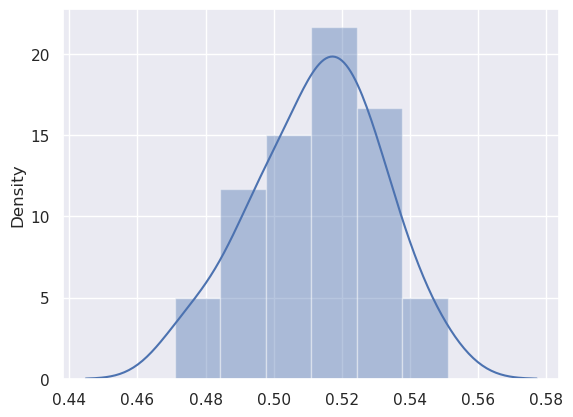

In [40]:
sns.distplot(df[['original', 'correctness']].groupby('original').mean())

In [41]:
train_df.correctness.value_counts()

True     23071
False    21929
Name: correctness, dtype: int64

In [42]:
accs = train_df[['original', 'label', 'correctness']].groupby(['original', 'label']).mean()

l = []
for w1 in df['original'].unique():
    acc = accs.loc[w1,True] * 0.5 + accs.loc[w1,False] * 0.5
    l.append((w1, acc[0]))

In [43]:
np.mean([ i[1] for i in l ])

0.512688888888889